## setup

In [1]:
import numpy as np
import time
import pandas as pd
import os
import random


import PIL.Image as Image
import matplotlib.pylab as plt
from tqdm import tqdm
from textwrap import wrap

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam, RMSprop

import datetime

%load_ext tensorboard

### use gpu

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

print('Num Gpu Avaible' ,len(physical_devices))

Num Gpu Avaible 1


In [3]:
tf.test.is_built_with_cuda

<function tensorflow.python.platform.test.is_built_with_cuda()>

In [4]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

### Read name file classes.txt

In [5]:
f = open('label_name.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

label                        name
0       1            rice leaf roller
1       2       rice leaf caterpillar
2       3           paddy stem maggot
3       4          asiatic rice borer
4       5           yellow rice borer
..    ...                         ...
97     98        Chlumetia transversa
98     99  Mango flat beak leafhopper
99    100  Rhytidodera bowrinii white
100   101       Sternochetus frigidus
101   102                Cicadellidae

[102 rows x 2 columns]

In [6]:
train_df = pd.read_csv('train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

image_path  label
0  00002.jpg      0
1  00003.jpg      0
2  00005.jpg      0
3  00006.jpg      0
4  00008.jpg      0

## Data preprocessing

## load dataset from directory

In [55]:
train_dir = 'classification/ip102_v1.1/test'
test_dir = 'classification/ip102_v1.1/train'
validation_dir = 'classification/ip102_v1.1/val'


BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset  = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             shuffle=True,
                                                            image_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE
                                                            )

validation_dataset   = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)


test_dataset  = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)                                                               

Found 22619 files belonging to 102 classes.
Found 7508 files belonging to 102 classes.
Found 45095 files belonging to 102 classes.


### read name insect pest 

In [8]:
class_names = np.array(classes.name)
print(class_names)

['rice leaf roller' 'rice leaf caterpillar' 'paddy stem maggot'
 'asiatic rice borer' 'yellow rice borer' 'rice gall midge' 'Rice Stemfly'
 'brown plant hopper' 'white backed plant hopper'
 'small brown plant hopper' 'rice water weevil' 'rice leafhopper'
 'grain spreader thrips' 'rice shell pest' 'grub' 'mole cricket'
 'wireworm' 'white margined moth' 'black cutworm' 'large cutworm'
 'yellow cutworm' 'red spider' 'corn borer' 'army worm' 'aphids'
 'Potosiabre vitarsis' 'peach borer' 'english grain aphid' 'green bug'
 'bird cherry-oataphid' 'wheat blossom midge' 'penthaleus major'
 'longlegged spider mite' 'wheat phloeothrips' 'wheat sawfly'
 'cerodonta denticornis' 'beet fly' 'flea beetle' 'cabbage army worm'
 'beet army worm' 'Beet spot flies' 'meadow moth' 'beet weevil'
 'sericaorient alismots chulsky' 'alfalfa weevil' 'flax budworm'
 'alfalfa plant bug' 'tarnished plant bug' 'Locustoidea' 'lytta polita'
 'legume blister beetle' 'blister beetle' 'therioaphis maculata Buckton'
 'odont

###  Show the 102  images and labels from the training set:



In [25]:
import pathlib 
import numpy as np

data_dir = pathlib.Path("classification/ip102_v1.1/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory 
print(class_names)

['Adristyrannus' 'Aleurocanthus spiniferus' 'Ampelophaga'
 'Aphis citricola Vander Goot' 'Apolygus lucorum' 'Bactrocera tsuneonis'
 'Beet spot flies' 'Brevipoalpus lewisi McGregor' 'Ceroplastes rubens'
 'Chlumetia transversa' 'Chrysomphalus aonidum' 'Cicadella viridis'
 'Cicadellidae' 'Colomerus vitis' 'Dacus dorsalis(Hendel)' 'Dasineura sp'
 'Deporaus marginatus Pascoe' 'Erythroneura apicalis'
 'Icerya purchasi Maskell' 'Lawana imitata Melichar' 'Limacodidae'
 'Locustoidea' 'Lycorma delicatula' 'Mango flat beak leafhopper' 'Miridae'
 'Nipaecoccus vastalor' 'Panonchus citri McGregor' 'Papilio xuthus'
 'Parlatoria zizyphus Lucus' 'Phyllocnistis citrella Stainton'
 'Phyllocoptes oleiverus ashmead' 'Pieris canidia'
 'Polyphagotars onemus latus' 'Potosiabre vitarsis' 'Prodenia litura'
 'Pseudococcus comstocki Kuwana' 'Rhytidodera bowrinii white'
 'Rice Stemfly' 'Salurnis marginella Guerr' 'Scirtothrips dorsalis Hood'
 'Sternochetus frigidus' 'Tetradacus c Bactrocera minax' 'Thrips'
 'Toxop

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 235
Number of test batches: 1410


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.



In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.



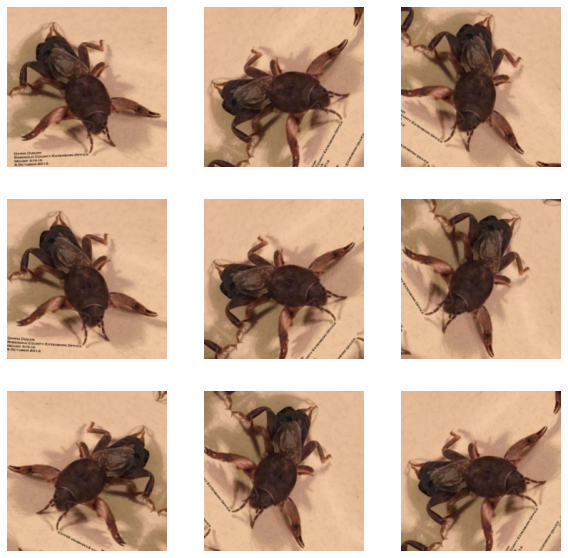

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV3` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input


### Create the base model from the pre-trained convnets

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)



## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

In [17]:
base_model.trainable = False

In [18]:
base_model.summary()


Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

### Add a classification head

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [20]:
num_classes = len(class_names)# 7

prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1280,activation="relu")(x)
x =  tf.keras.layers.Dropout(rate=0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               130662

In [22]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Train the model


In [23]:
NUM_EPOCHS = 10

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=NUM_EPOCHS)

Epoch 1/10
707/707 [==============================] - 69s 91ms/step - loss: 2.3238 - accuracy: 0.4453 - val_loss: 1.9342 - val_accuracy: 0.5188A: 41s - loss: 3.9339 - accuracy: 0. - ETA: 41s - loss: 3.8768 -  - ETA: 40s - loss: 3.5974 - accuracy:  - ETA:  - ETA: 38s - loss: 3.1717 - accura - ETA: 38s - - ETA: 0s - loss: 2.3296 - ac
Epoch 2/10
707/707 [==============================] - 48s 67ms/step - loss: 1.6676 - accuracy: 0.5677 - val_loss: 1.9010 - val_accuracy: 0.5530
Epoch 3/10
707/707 [==============================] - 47s 66ms/step - loss: 1.3791 - accuracy: 0.6339 - val_loss: 2.0128 - val_accuracy: 0.5464
Epoch 4/10
707/707 [==============================] - 57s 80ms/step - loss: 1.1855 - accuracy: 0.6804 - val_loss: 2.1744 - val_accuracy: 0.5587
Epoch 5/10
707/707 [==============================] - 46s 65ms/step - loss: 1.0186 - accuracy: 0.7209 - val_loss: 2.3809 - val_accuracy: 0.5738
Epoch 6/10
707/707 [==============================] - 57s 80ms/step - loss: 0.9104 - accur

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

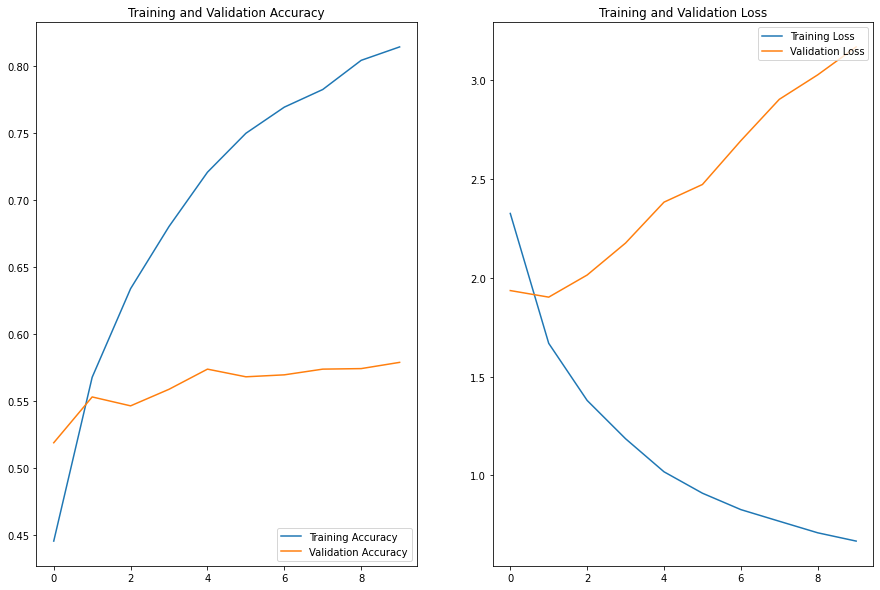

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## FINE TUNING

### Un-freeze the top layers of the model


In [45]:
base_model.trainable = True

In [46]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  269


### Compile the model


In [48]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               1306

In [50]:
len(model.trainable_variables)

135

### Continue training the model

In [51]:
fine_tune_epochs = 10
total_epochs =  NUM_EPOCHS  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
1410/1410 [==============================] - 183s 123ms/step - loss: 0.8680 - accuracy: 0.7693 - val_loss: 2.4368 - val_accuracy: 0.6145
Epoch 11/20
1410/1410 [==============================] - 175s 124ms/step - loss: 0.7650 - accuracy: 0.7909 - val_loss: 2.4622 - val_accuracy: 0.6212
Epoch 12/20
1410/1410 [==============================] - 167s 118ms/step - loss: 0.7212 - accuracy: 0.8030 - val_loss: 2.3266 - val_accuracy: 0.6256
Epoch 13/20
1410/1410 [==============================] - 166s 117ms/step - loss: 0.6751 - accuracy: 0.8119 - val_loss: 2.3496 - val_accuracy: 0.6291
Epoch 14/20
1410/1410 [==============================] - 164s 116ms/step - loss: 0.6455 - accuracy: 0.8176 - val_loss: 2.3042 - val_accuracy: 0.6332
Epoch 15/20
1410/1410 [==============================] - 173s 123ms/step - loss: 0.6118 - accuracy: 0.8259 - val_loss: 2.3551 - val_accuracy: 0.6357
Epoch 16/20
1410/1410 [==============================] - 176s 125ms/step - loss: 0.5943 - accuracy: 0.8302

In [53]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

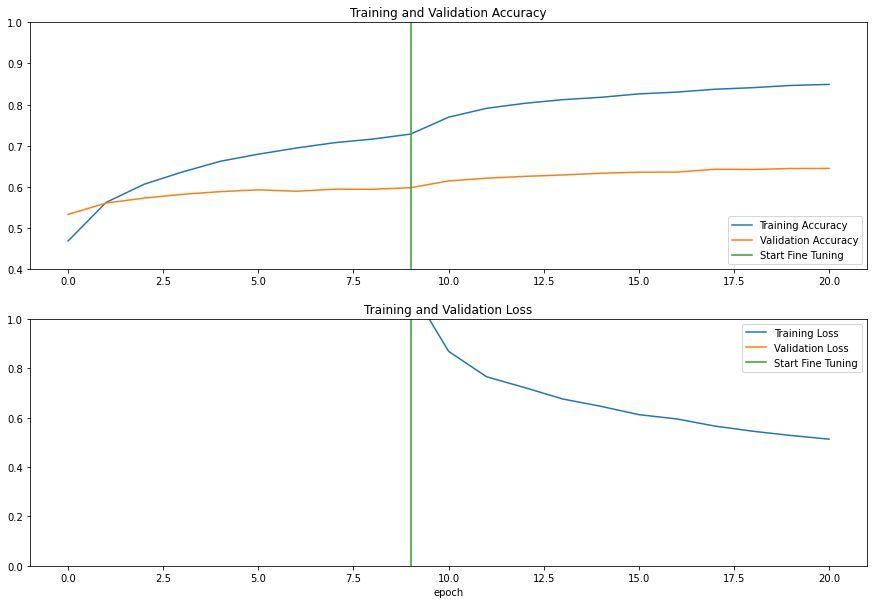

In [54]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [27]:
test_score = model.evaluate(test_dataset)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

1410/1410 [==============================] - 75s 53ms/step - loss: 3.1918 - accuracy: 0.5694: 1:02 - loss: 3.4742 - accu - ETA: 59s  - ETA: 56s - - ETA: 53s - loss: 2.4788 - accuracy: 0.676 - ETA: 53s - loss: 2.4733 - accuracy: 0. - ETA: 53s - loss: 2.4564 - accuracy:  - ETA: 53s - loss: 2.4351 - accurac - ETA: 52s - loss: 2.4065 - a - ETA: 51s - loss: 2.3648 - ETA: 50s - l - ETA: 48s - loss: 2.2134 - accurac - ETA: 47s - loss: 2.1674 - accuracy: 0.70 - ETA: 47s - loss: 2 - ETA: 45s - l - ETA: 39s - loss: 2.3639 - accurac - ETA: 39s - loss: 2.3923 - - ETA: 38s - loss: 2.4972 - accurac - ETA: 31s - loss: 2.6650 - accuracy: 0.645 - ETA: 31s - loss: 2 - ETA: 2 - ETA: 0s - loss: 3.1901 - accuracy
[INFO] accuracy: 56.94%
[INFO] Loss:  3.1918020248413086


In [108]:
loss, accuracy = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)

1410/1410 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.92 - 70s 50ms/step - loss: 0.2315 - accuracy: 0.9251
Test accuracy : 0.9250914454460144


In [64]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['corn borer' 'bird cherry-oataphid' 'tarnished plant bug' 'meadow moth'
 'peach borer' 'rice water weevil' 'Deporaus marginatus Pascoe' 'Miridae'
 'Icerya purchasi Maskell' 'alfalfa seed chalcid' 'corn borer'
 'corn borer' 'flea beetle' 'Lycorma delicatula' 'blister beetle'
 'Miridae' 'blister beetle' 'Miridae' 'white backed plant hopper' 'aphids'
 'Tetradacus c Bactrocera minax' 'alfalfa plant bug' 'meadow moth'
 'white backed plant hopper' 'wheat sawfly' 'mole cricket' 'Dasineura sp'
 'small brown plant hopper' 'Miridae' 'Cicadellidae' 'Locustoidea'
 'brown plant hopper']


In [ ]:
predictions = model.predict(test_dataset)
preds = np.argmax(predictions, axis=1)
preds

In [ ]:
labels = train_dataset
labels = dict((v,k) for k,v in labels.te)
preds = [labels[k] for k in preds]
preds

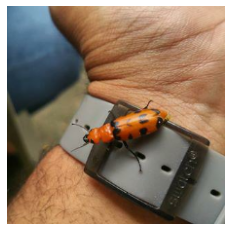

True label: Aleurocanthus spiniferus
Predicted label: blister beetle


In [59]:
x, y = next(iter(validation_dataset))
image = x[0, :, :, :]
true_index = np.argmax(y)
plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

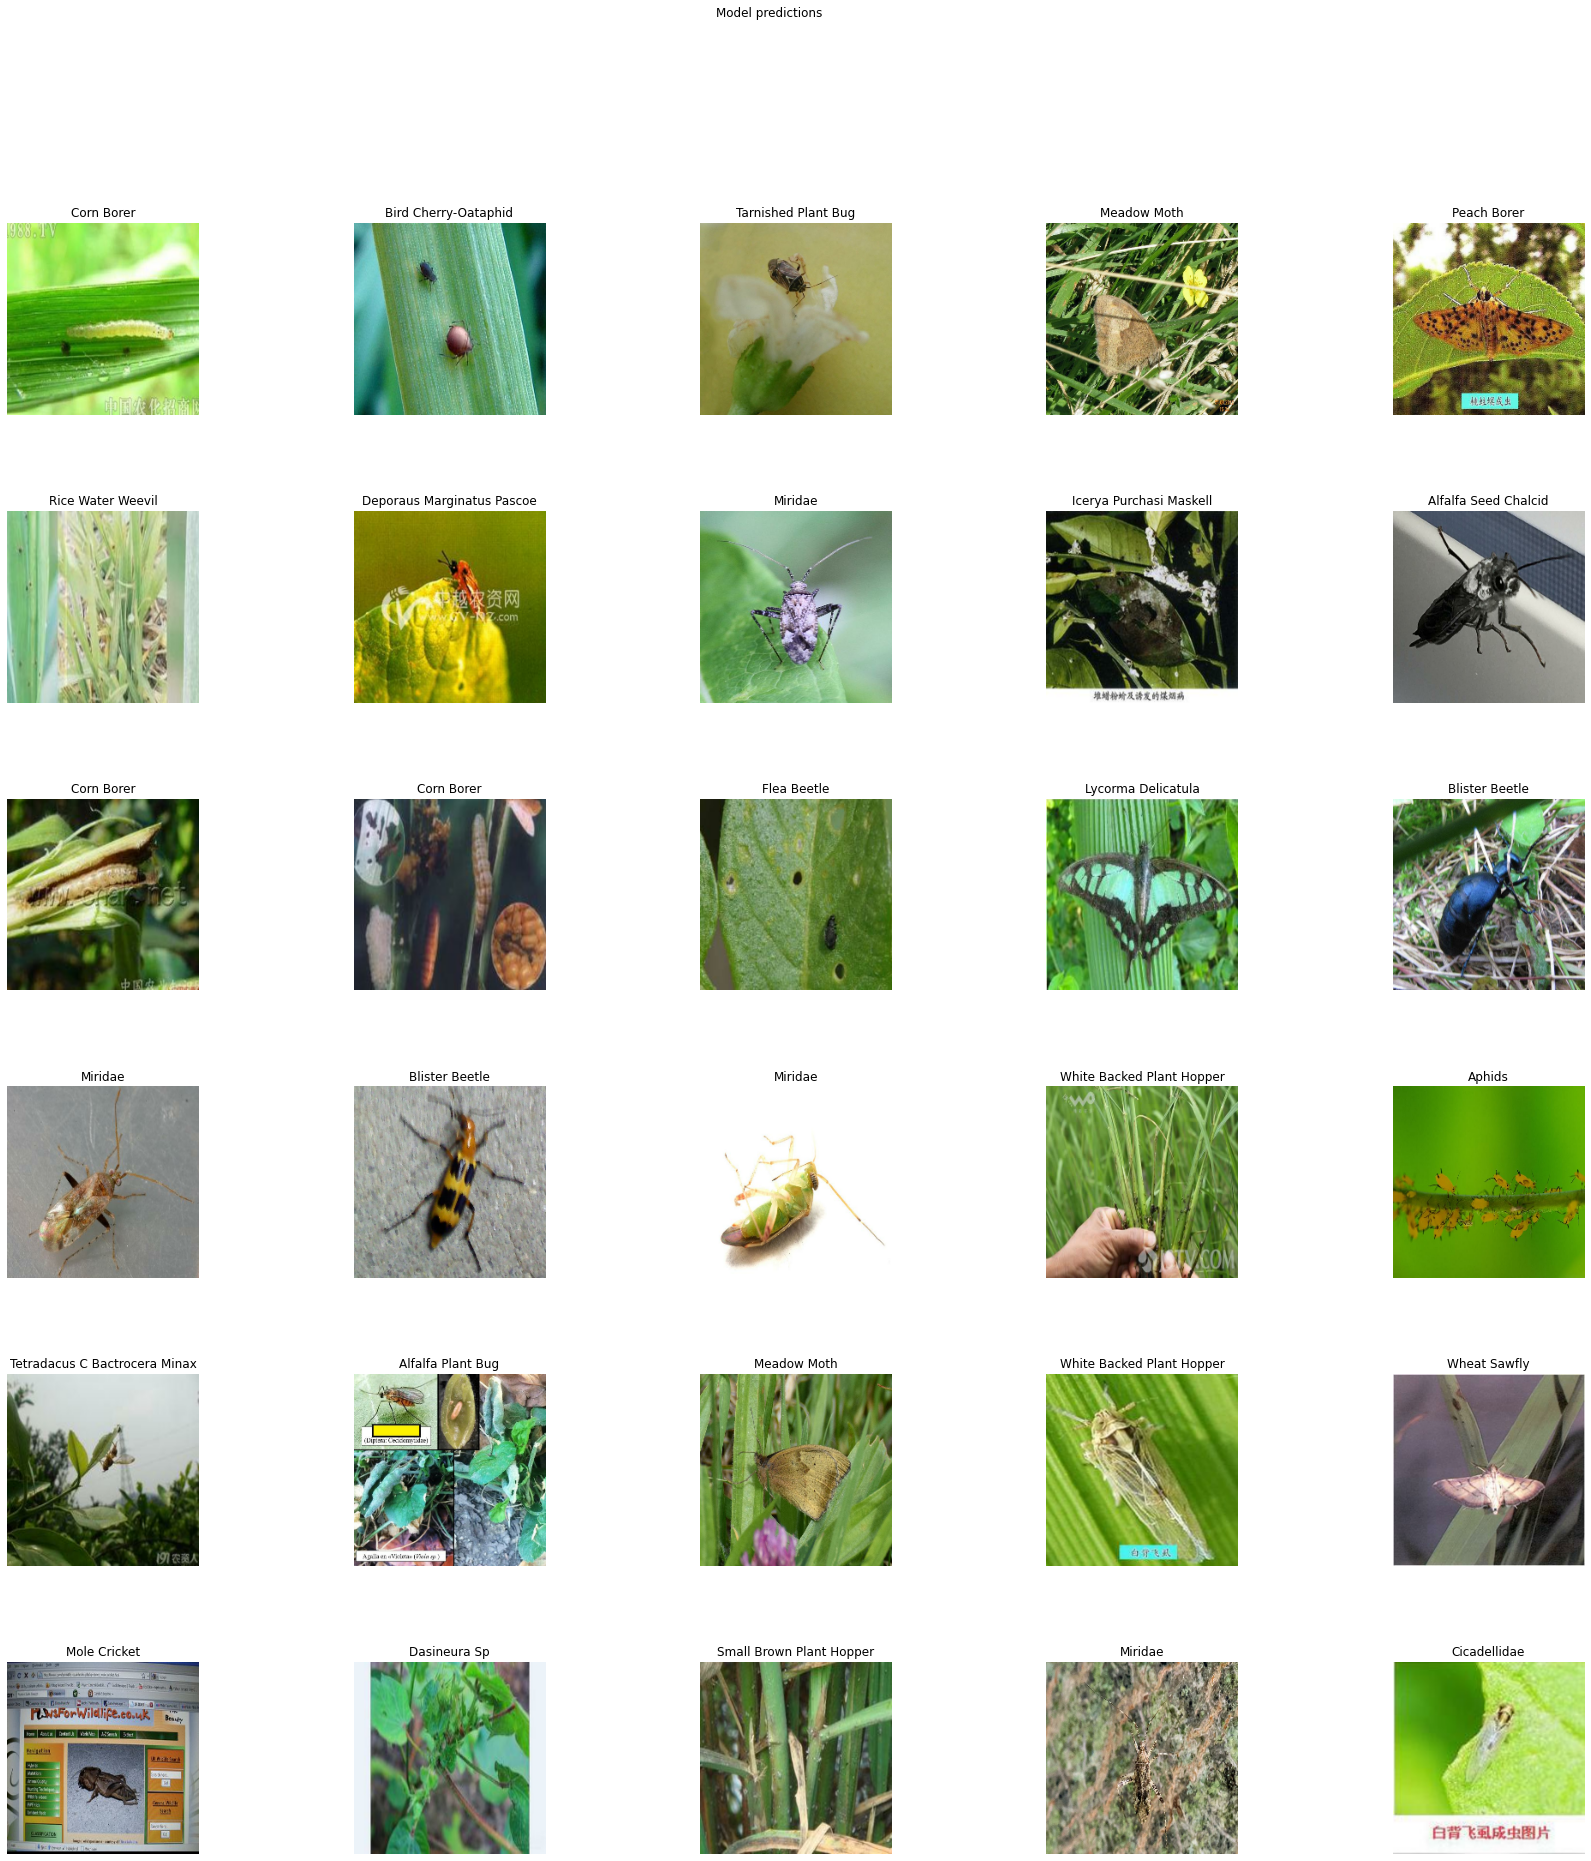

In [63]:
plt.figure(figsize=(30,30))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n].numpy().astype('uint8'))
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [66]:
result_batch = model.predict(train_dataset)


In [67]:
predicted_class_names = class_names[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Colomerus vitis', 'Limacodidae', 'Lycorma delicatula', ...,
       'Trialeurodes vaporariorum', 'blister beetle', 'Apolygus lucorum'],
      dtype='<U31')

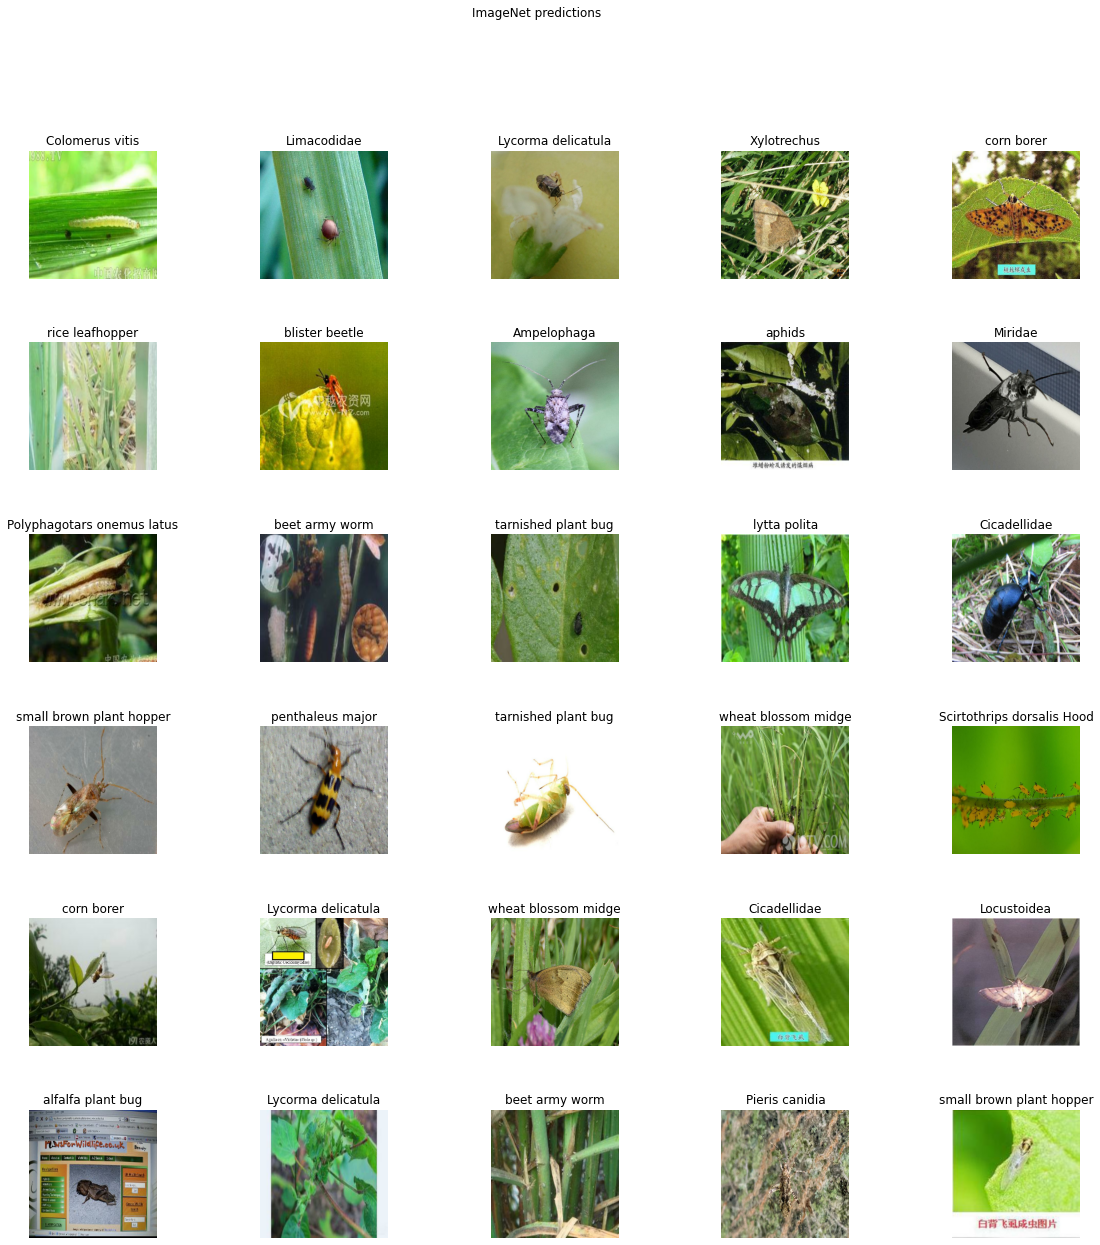

In [70]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n].numpy().astype('uint8'))
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [60]:
plt.figure()
plt.imshow(train_dataset[0])
plt.colorbar()
plt.grid(False)
plt.show()

TypeError: 'BatchDataset' object is not subscriptable

<Figure size 432x288 with 0 Axes>

In [46]:
predictions = model.predict(test_dataset)

In [52]:
labels = {value: key for key, value in train_dataset.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

AttributeError: 'PrefetchDataset' object has no attribute 'class_indices'

TypeError: 'PrefetchDataset' object is not subscriptable

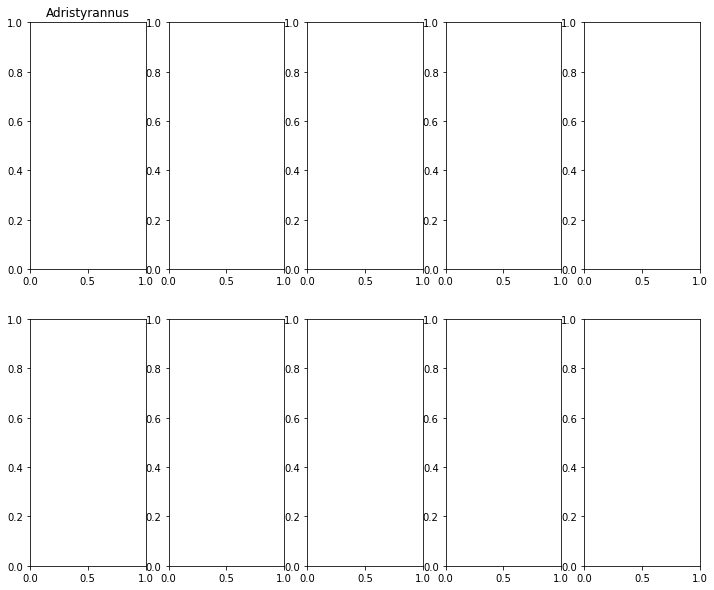

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = class_names[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_dataset[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [75]:
insect = tf.keras.utils.get_file('imagS.JPG','https://insectscience.co.za/wp-content/uploads/elementor/thumbs/Brown-cutworm-Agrotis-longidentifera.-Larval-damage-to-potato-tuber.-D.-Visser-ARC-pe5ns2fpiw9zj0tfrq1ckpqd25dcchgx096rsdro5c.png')
insect = Image.open(insect).resize(IMG_SHAPE)
insect

344064/329287 [===============================] - 54s 158us/step


TypeError: argument 1 must be sequence of length 2, not 3

### saved model

In [154]:
model_name = "mobilenetv3" 

saved_model_path = f"/tmp/MODEL{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/MODELmobilenetv3\assets


## Deployment to TensorFlow Lite

In [158]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"


In [159]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\angga\AppData\Local\Temp\tmpxbbccdfd\assets


c:\Users\angga\anaconda3\envs\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [160]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

23909168

In [155]:
import itertools


optimize_lite_model = True 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_dataset for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/MODEL{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 6540104 bytes.
